### This notebook gathers data from Chicagos open data website in order to compare crime levels from 2018, 2019, and 2020 during the same period to gain a better understanding of how the mandated quarantine order has affected the crime rate in the city of Chicago. 
Data Source: (https://data.cityofchicago.org/Public-Safety/Crimes-2001-to-present/ijzp-q8t2)


Importing dependencies and making day/ month variables

In [1]:
#importing dependencies and setting app token
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, datetime
from sodapy import Socrata
import csv
import sqlite3
crime_data = "ijzp-q8t2"
MyAppToken = 'GuILMuJLLhVOQ8u9cyXPc56p3'
client = Socrata("data.cityofchicago.org", MyAppToken)


#checking the day of the month and printing the result, this is used to filter the dataframe later
today = date.today()
daynum = today.strftime("%d")
month = today.strftime("%m")
day = int(daynum) - 7
print(f"Day: {day} \nMonth: {month}")

Day: 10 
Month: 04


Making api call inside getData to store data into one combined dataframe

In [2]:
def getData(year):
    where_clause = f"Date BETWEEN '{year}-01-01' AND '{year}-{month}-{day}'";
    #where_clause = where_clause + " AND  'Primary Type' IN ('THEFT', 'BATTERY')"
    #where_clause = "'Primary Type' IN ('THEFT', 'BATTERY')"
    
    df = pd.DataFrame(
        client.get(
            crime_data, 
            where=where_clause,
            limit=100000,
            exclude_system_fields=True
        )
    )
    client.close()

    #reformatting the data from the api call and organizing the results
    df['day'] = pd.DatetimeIndex(df['date']).day
    df['month'] = pd.DatetimeIndex(df['date']).month
    df['year'] = pd.DatetimeIndex(df['date']).year
    df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
    df['month_day'] = pd.to_datetime(df['date']).dt.strftime('%m-%d')
    df["primary_type"] = df["primary_type"].str.lower().str.title()

    # Organize column order: 
    dfReturn = df[[
         "primary_type"
        , "date"
        , "month_day"
        , "day"
        , "month"
        , "year"
        , "domestic"
    ]]
    
    return dfReturn;

In [3]:
df2020 = getData('2020');
df2019 = getData('2019');
df2018 = getData('2018');

In [4]:
print(f"2020: {df2020.shape} 2019: {df2019.shape} 2018: {df2018.shape}")

2020: (56947, 7) 2019: (64649, 7) 2018: (64939, 7)


In [5]:
#combining the 2019 and 2020 dataframes into one
dataframes = [df2018, df2019, df2020]
final_df = pd.concat(dataframes)
print(final_df.shape)
final_df.head()

(186535, 7)


,primary_type,date,month_day,day,month,year,domestic
0,Criminal Sexual Assault,2018-01-01,01-01,1,1,2018,False
1,Offense Involving Children,2018-01-01,01-01,1,1,2018,True
2,Offense Involving Children,2018-01-01,01-01,1,1,2018,False
3,Battery,2018-01-01,01-01,1,1,2018,True
4,Offense Involving Children,2018-01-01,01-01,1,1,2018,True


In [6]:
#To access this table in flask app call the name chicago -> chicago.query.count()

## Aggs and Group By's

By Date 

In [7]:
aggs_overall = final_df.groupby(["date", "month_day"]).agg({'day': [np.count_nonzero]}).reset_index() 
aggs_overall.columns = ["date", "month_day", "crimes_committed"]
aggs_overall.head()
#aggs_overall.to_csv("final_Chicago_data_total_crime_by_date.csv")

,date,month_day,crimes_committed
0,2018-01-01,01-01,895
1,2018-01-02,01-02,559
2,2018-01-03,01-03,574
3,2018-01-04,01-04,601
4,2018-01-05,01-05,663


### Rolling Mean Visual utilizing this Agg

In [8]:
dfCSV = aggs_overall.set_index('date') # creates a DateTimeIndex - req'd by .resample()
# set number of days and standard deviations to use for rolling 
# lookback period for Bollinger band calculation
window = 3
no_of_std = 1.5

# calculate rolling mean and standard deviation
rolling_mean = dfCSV['crimes_committed'].rolling(window).mean()
rolling_std = dfCSV['crimes_committed'].rolling(window).std()

# create two new DataFrame columns to hold values of upper and lower Bollinger bands
dfCSV['Rolling_Mean'] = rolling_mean
dfCSV['Bollinger_High'] = rolling_mean + (rolling_std * no_of_std)
dfCSV['Bollinger_Low'] = rolling_mean - (rolling_std * no_of_std)

In [9]:
dfCSV_2018 = dfCSV.loc["2018-01-01": "2018-04-07"].copy()
dfCSV_2019 = dfCSV.loc["2019-01-01": "2019-04-07"].copy()
dfCSV_2020 = dfCSV.loc["2020-01-01": "2020-04-07"].copy()

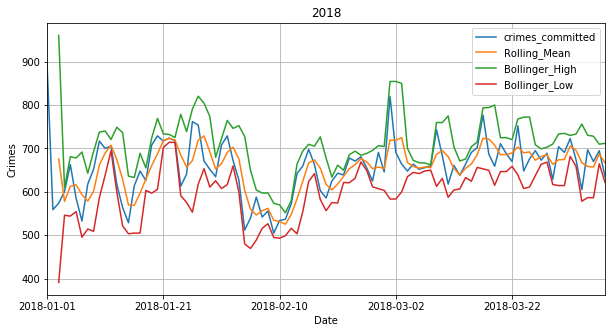

In [10]:
dfCSV_2018[['crimes_committed','Rolling_Mean', 'Bollinger_High','Bollinger_Low']].plot(grid=True,figsize=(10,5))
plt.title('2018')
plt.ylabel('Crimes')
plt.xlabel('Date')
plt.legend()
plt.show()

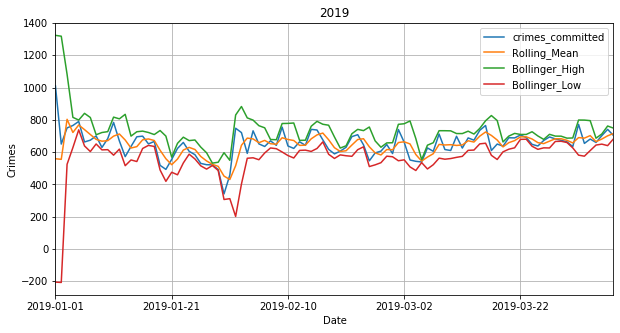

In [11]:
dfCSV_2019[['crimes_committed','Rolling_Mean', 'Bollinger_High','Bollinger_Low']].plot(grid=True,figsize=(10,5))
plt.title('2019')
plt.ylabel('Crimes')
plt.xlabel('Date')
plt.legend()
plt.show()

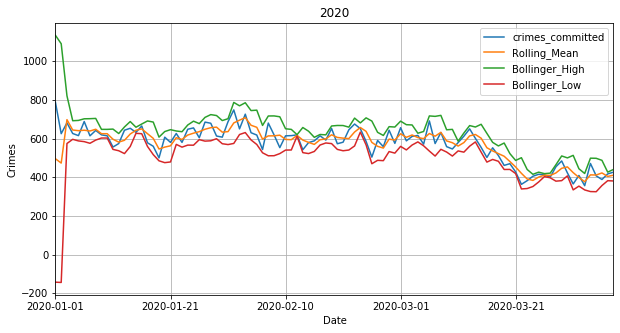

In [12]:
dfCSV_2020[['crimes_committed','Rolling_Mean', 'Bollinger_High','Bollinger_Low']].plot(grid=True,figsize=(10,5))
plt.title('2020')
plt.ylabel('Crimes')
plt.xlabel('Date')
plt.legend()
plt.show()

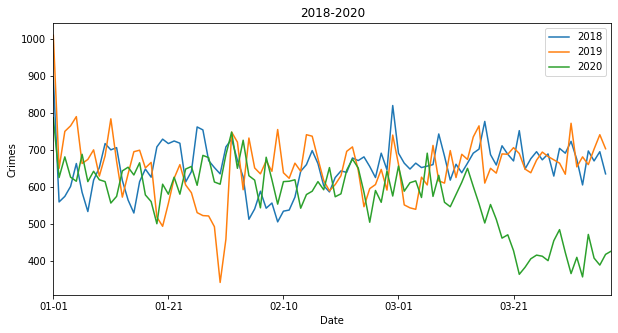

In [13]:
ax = dfCSV_2018.plot(
    x='month_day'
    , figsize=(10,5)
    , y='crimes_committed'
    , label='2018'
) 
dfCSV_2019.plot(
    ax=ax,
    x='month_day'
    , figsize=(10,5)
    , y='crimes_committed'
    , label='2019'
) 
dfCSV_2020.plot(
    ax=ax,
    x='month_day'
    , figsize=(10,5)
    , y='crimes_committed'
    , label='2020'
)
plt.title('2018-2020')
plt.ylabel('Crimes')
plt.xlabel('Date')
plt.legend()
plt.show()

By date and primary type of crime

In [14]:
aggs_by_date_type = final_df.groupby(["date", "month_day", "primary_type"]).agg({'day': [np.count_nonzero]}).reset_index() 
aggs_by_date_type.columns = ["date", "month_day", "primary_type", "crimes_committed"]
aggs_by_date_type = aggs_by_date_type.set_index(pd.DatetimeIndex(aggs_by_date_type['date']))
aggs_by_date_type = aggs_by_date_type.drop(['date'], axis=1)
aggs_by_date_type.head()

,month_day,primary_type,crimes_committed
date,,,
2018-01-01,01-01,Assault,38
2018-01-01,01-01,Battery,161
2018-01-01,01-01,Burglary,32
2018-01-01,01-01,Crim Sexual Assault,16
2018-01-01,01-01,Criminal Damage,66


In [15]:
grouped_primary_type = final_df.groupby(['date',  'year','month', 'primary_type']).count()
grouped_primary_type = grouped_primary_type.drop(columns = ['day','month_day'])
grouped_primary_type = grouped_primary_type.rename(columns={"domestic": "total_crimes"})
grouped_primary_type.reset_index(inplace=True)
grouped_primary_type.head()

,date,year,month,primary_type,total_crimes
0,2018-01-01,2018,1,Assault,38
1,2018-01-01,2018,1,Battery,161
2,2018-01-01,2018,1,Burglary,32
3,2018-01-01,2018,1,Crim Sexual Assault,16
4,2018-01-01,2018,1,Criminal Damage,66


In [16]:
grouped_month_day = final_df.groupby(['month_day', 'year','domestic']).count()
grouped_month_day = grouped_month_day.drop(columns = ['date','day','month'])
grouped_month_day = grouped_month_day.rename(columns={"primary_type": "month_total_crimes"})
grouped_month_day.reset_index(inplace=True)
grouped_month_day.head()

,month_day,year,domestic,month_total_crimes
0,01-01,2018,False,676
1,01-01,2018,True,219
2,01-01,2019,False,795
3,01-01,2019,True,215
4,01-01,2020,False,596


-----------------------------------------------------

## Converting everything to sqlite database for Flask App

In [17]:
#creates sql lite file called chicago_data and adds a cursor so we can create queries
db = sqlite3.connect('chicago_data.db')

In [18]:
#inserts only new values from api call into sqlite file
final_df.to_sql('chicago_data', db, if_exists = 'replace')
aggs_overall.to_sql('aggs_overall', db, if_exists = 'replace')
aggs_by_date_type.to_sql('aggs_by_date_type', db, if_exists = 'replace')
dfCSV.to_sql('dfCSV', db, if_exists = 'replace')
grouped_primary_type.to_sql('group_type_df', db, if_exists = 'replace')
grouped_month_day.to_sql('groupby_df', db, if_exists = 'replace')

In [19]:
db.close()